In [118]:
from onstove.raster import *
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib
import numpy as np
import psycopg2
from decouple import config
import plotly.express as px
import pandas as pd
import seaborn as sns
from sklearn.cluster import DBSCAN

In [2]:
POSTGRES_USER = config('POSTGRES_USER')
POSTGRES_KEY = config('POSTGRES_KEY')

conn = psycopg2.connect(
   database="nepal", user=POSTGRES_USER, password=POSTGRES_KEY
)

In [3]:
pop_path = 'data/population_npl_2018-10-01_3857_100x100.tif'
with rasterio.open(pop_path) as src:
    population = src.read(1)
    population_meta = src.meta

In [4]:
def align_raster(raster_1, raster_2, method='nearest', compression='NONE'):
    with rasterio.open(raster_1) as src:
        raster_1_meta = src.meta
    with rasterio.open(raster_2) as src:
        raster_2 = src.read(1)
        raster_2_meta = src.meta

    out_meta = raster_1_meta.copy()
    out_meta.update({
        'transform': raster_1_meta['transform'],
        'crs': raster_1_meta['crs'],
        'compress': compression
    })    
    destination = np.full((raster_1_meta['height'], raster_1_meta['width']), raster_2_meta['nodata'])
    reproject(
            source=raster_2,
            destination=destination,
            src_transform=raster_2_meta['transform'],
            src_crs=raster_2_meta['crs'],
            dst_transform=raster_1_meta['transform'],
            dst_crs=raster_1_meta['crs'],
            resampling=Resampling[method])
    return destination, out_meta
    

In [5]:
npp, npp_meta = align_raster(pop_path, 
                             'data/npp_2020_average_masked.tif',
                             method='nearest')

In [6]:
land_cover, land_cover_meta = align_raster(pop_path, 
                          'data/MCD12Q1_type1.tif',
                          method='nearest')

In [7]:
# npp_pop = (population>0) * (land_cover==13) * (npp>0.35) * npp
npp_pop = (population>0) * (npp>0) * npp

In [8]:
np.nanmax(npp_pop)

41.46933364868164

In [9]:
np.nansum(population[npp_pop>0])

14026879.11888571

In [13]:
sql = 'SELECT * FROM admin.npl_admbnda_adm0_nd_20201117'
adm0 = gpd.read_postgis(sql, conn)
shapes = ((g, 1) for g in adm0.to_crs(3857)['geom'].values)

with rasterio.open(pop_path) as src:
    mask = features.rasterize(
                shapes,
                out_shape=src.shape,
                transform=src.transform,
                all_touched=False,
                fill=0)
mask[population>0] = 1

In [14]:
npp_pop[mask==0] = np.nan
npp_pop_copy = npp_pop.copy()
npp_pop_copy[npp_pop_copy==0] = -9999

In [15]:
with rasterio.open(pop_path) as src:
    bounds = src.bounds
    extent = [bounds[0], bounds[2], bounds[1], bounds[3]] # [left, right, bottom, top]

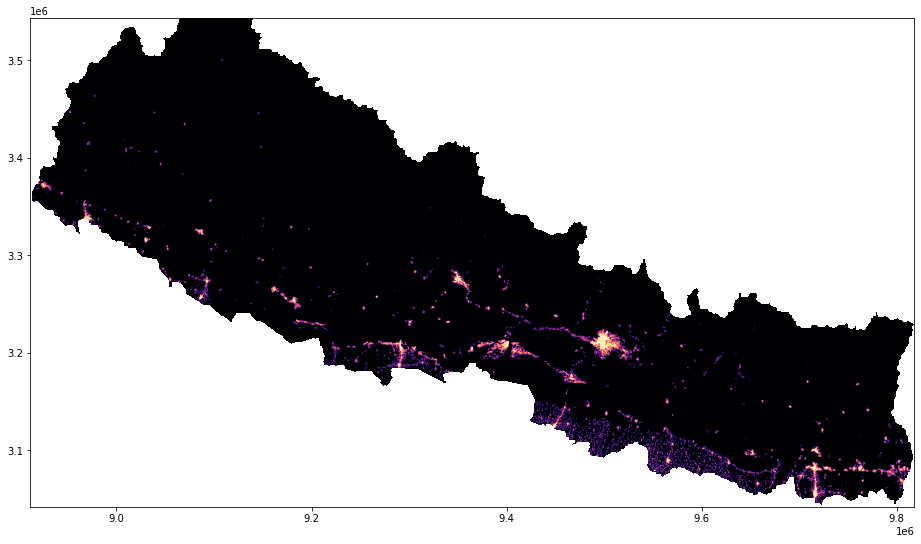

In [16]:
cmap = matplotlib.cm.get_cmap("magma", 2)
fig, ax = plt.subplots(1, 1, figsize=(16,9))
ax.imshow(npp_pop_copy, extent=extent, cmap='magma')

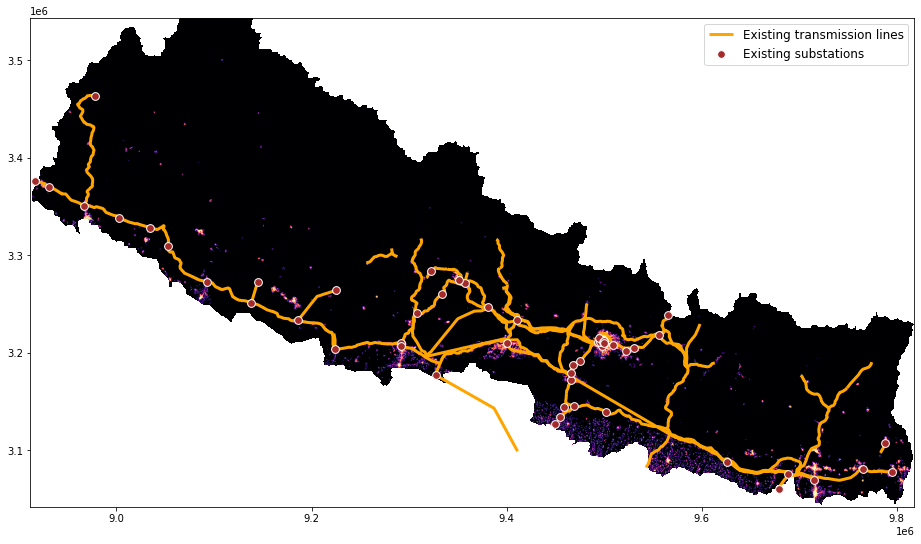

In [17]:
cmap = matplotlib.cm.get_cmap("magma", 2)
fig, ax = plt.subplots(1, 1, figsize=(16,9))

sql = 'SELECT * FROM power_network.substations_georeferenced'
df_sub = gpd.read_postgis(sql, conn)
sql = 'SELECT * FROM power_network.hv_lines_georeferenced'
df_hv = gpd.read_postgis(sql, conn)
df_hv.loc[df_hv['status']=='E'].to_crs(epsg=3857).plot(color='orange', linewidth=3, ax=ax, label='Existing transmission lines', zorder=1)
df_sub.loc[df_sub['status']=='E'].to_crs(epsg=3857).plot(color='brown', ax=ax,  linewidth=1, edgecolor='white',
                                                         markersize=60, label='Existing substations', zorder=10)

ax.imshow(npp_pop_copy, extent=extent, cmap='magma', zorder=0)

lgnd = ax.legend(loc="upper right", prop={'size': 12})
lgnd.legendHandles[0]._sizes = [60]

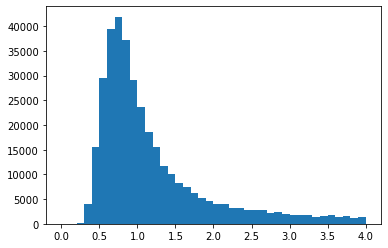

In [18]:
plt.hist(npp_pop[npp_pop>0], bins=40, range=(0, 4))
plt.show()

In [103]:
rows, cols = np.where(population>0)

In [104]:
x, y = rasterio.transform.xy(population_meta['transform'], 
                             rows, cols, 
                             offset='center')
coords = np.column_stack((x, y))

In [145]:
labels = DBSCAN(eps=300, min_samples=5).fit_predict(coords)

In [146]:
clusters = population.copy()
clusters[rows, cols] = labels
clusters[np.isnan(clusters)] = -9999

In [147]:
out_meta = population_meta.copy()
out_meta.update(compression='DEFLATE',
                dtype=rasterio.int32,
                nodata=-9999)

with rasterio.open('data/clusters.tif', 'w', **out_meta) as dst:
    dst.write(clusters.astype(int), 1)

In [20]:
quantiles = np.quantile(npp_pop[npp_pop>0], [0.25, 0.5, 0.75])
quantiles

array([0.7171434 , 0.98023498, 1.63792217])

In [21]:
p25 = npp_pop[(npp_pop>0) & (npp_pop<quantiles[0])]
p50 = npp_pop[(npp_pop>0) & (npp_pop<quantiles[1])]
p75 = npp_pop[(npp_pop>0) & (npp_pop<quantiles[2])]

In [22]:
df = pd.DataFrame({'npp': p25})
df['percentile'] = 'p25'
df = df.append(pd.DataFrame({'npp': p50, 'percentile': 'p50'}), ignore_index=True)
df = df.append(pd.DataFrame({'npp': p75, 'percentile': 'p75'}), ignore_index=True)

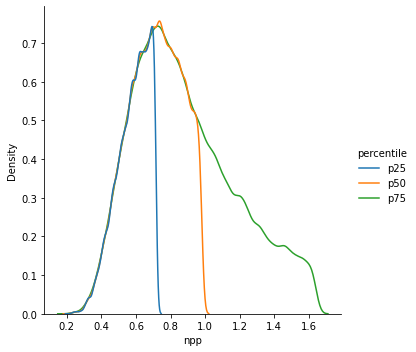

In [23]:
sns.displot(df, x='npp', hue='percentile', kind="kde")

In [27]:
p_medians = df.groupby('percentile')[['npp']].median()
p_medians

,npp
percentile,
p25,0.595806
p50,0.717129
p75,0.833986


In [49]:
npp_tiers = npp_pop.copy()
npp_tiers[(npp_pop>0) & (npp_pop<p_medians.loc['p25'].values)] = 1
npp_tiers[(npp_pop>=p_medians.loc['p25'].values) & (npp_pop<p_medians.loc['p50'].values)] = 2
npp_tiers[(npp_pop>=p_medians.loc['p50'].values) & (npp_pop<p_medians.loc['p75'].values)] = 3
npp_tiers[(npp_pop>=p_medians.loc['p75'].values)] = 4

In [51]:
np.unique(npp_tiers[~np.isnan(npp_tiers)])

array([0., 1., 2., 3., 4.])

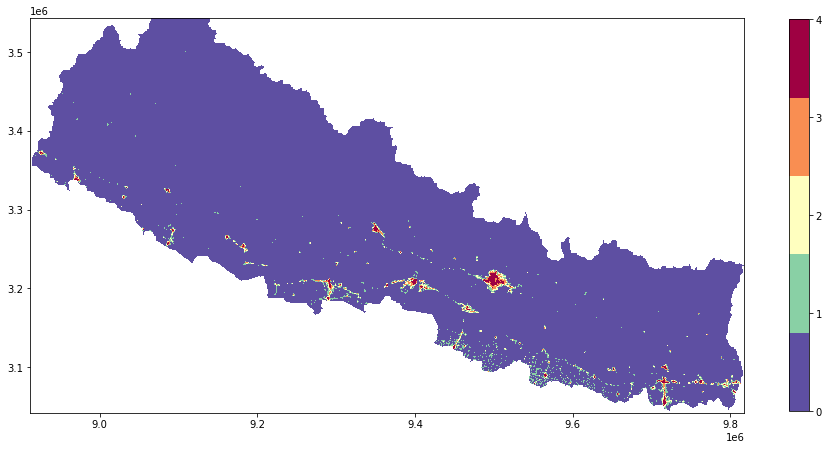

In [78]:
cmap = matplotlib.cm.get_cmap("Spectral_r", 5)
fig, ax = plt.subplots(1, 1, figsize=(16,9))
cax = ax.imshow(npp_tiers, extent=extent, cmap=cmap)
cbar = fig.colorbar(cax, shrink=0.8, ticks=[0, 1, 2, 3, 4])
# fig.savefig(f"data/tiers.png", dpi=300, bbox_inches='tight')

In [59]:
out_meta = population_meta.copy()
out_meta.update(compression='DEFLATE',
                dtype=rasterio.int32,
                nodata=0)

with rasterio.open('data/tiers.tif', 'w', **out_meta) as dst:
    dst.write(npp_tiers.astype(int), 1)